In [1]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dir = "/content/drive/My Drive/hydraulic"
os.listdir(dir)

['EPS1.txt',
 'FS1.txt',
 'FS2.txt',
 'CE.txt',
 'CP.txt',
 'PS1.txt',
 'PS2.txt',
 'PS3.txt',
 'PS4.txt',
 'PS5.txt',
 'PS6.txt',
 'SE.txt',
 'TS1.txt',
 'TS2.txt',
 'TS3.txt',
 'TS4.txt',
 'VS1.txt',
 'profile.txt',
 'documentation.txt',
 'description.txt']

In [4]:
for filename in os.listdir(dir):
    if filename.endswith(".txt"):
        filepath = os.path.join(dir, filename)
        try:
            with open(filepath, 'r') as f:
                lines = f.readlines()
                num_rows = len(lines)

                if num_rows > 0:
                    first_row = lines[0].strip()
                    numbers = first_row.split()
                    num_numbers = 0
                    for num_str in numbers:
                        try:
                            float(num_str)  # Check if it can be converted to float
                            num_numbers += 1
                        except ValueError:
                            pass
                    print(f"File: {filename}, Number of rows: {num_rows} Number of data in each row: {num_numbers}")
        except Exception as e:
            print(f"Error processing file {filename}: {e}")

File: EPS1.txt, Number of rows: 2205 Number of data in each row: 6000
File: FS1.txt, Number of rows: 2205 Number of data in each row: 600
File: FS2.txt, Number of rows: 2205 Number of data in each row: 600
File: CE.txt, Number of rows: 2205 Number of data in each row: 60
File: CP.txt, Number of rows: 2205 Number of data in each row: 60
File: PS1.txt, Number of rows: 2205 Number of data in each row: 6000
File: PS2.txt, Number of rows: 2205 Number of data in each row: 6000
File: PS3.txt, Number of rows: 2205 Number of data in each row: 6000
File: PS4.txt, Number of rows: 2205 Number of data in each row: 6000
File: PS5.txt, Number of rows: 2205 Number of data in each row: 6000
File: PS6.txt, Number of rows: 2205 Number of data in each row: 6000
File: SE.txt, Number of rows: 2205 Number of data in each row: 60
File: TS1.txt, Number of rows: 2205 Number of data in each row: 60
File: TS2.txt, Number of rows: 2205 Number of data in each row: 60
File: TS3.txt, Number of rows: 2205 Number of da

In [6]:
scalers = {}
classifiers = {}
regressor = None
lstm_model = None
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

def preprocess_sensor_data(sensor_df):
    """Convert tab-separated string data into numeric arrays."""
    # Split the string on tabs and convert to numeric values
    numeric_data = sensor_df[0].str.split('\t', expand=True).astype(float)
    return numeric_data

def load_and_preprocess_data( file_paths):
    """Load and preprocess the sensor data."""
    data = {}

    # Load all sensor data
    for sensor_type in ['PS', 'EPS1', 'FS', 'TS', 'VS1', 'SE', 'CE', 'CP']:
        if sensor_type == 'PS':
            for i in range(1, 7):
                raw_data = pd.read_csv(f'{file_paths}/PS{i}.txt', header=None)
                data[f'PS{i}'] = preprocess_sensor_data(raw_data)
        elif sensor_type == 'FS':
            for i in range(1, 3):
                raw_data = pd.read_csv(f'{file_paths}/FS{i}.txt', header=None)
                data[f'FS{i}'] = preprocess_sensor_data(raw_data)
        elif sensor_type == 'TS':
            for i in range(1, 5):
                raw_data = pd.read_csv(f'{file_paths}/TS{i}.txt', header=None)
                data[f'TS{i}'] = preprocess_sensor_data(raw_data)
        else:
            raw_data = pd.read_csv(f'{file_paths}/{sensor_type}.txt', header=None)
            data[sensor_type] = preprocess_sensor_data(raw_data)


    # Load profile data
    raw_data = pd.read_csv(f'{file_paths}/profile.txt', header=None)
    profile = preprocess_sensor_data(raw_data)
    profile.columns = ['cooler', 'valve', 'pump', 'accumulator', 'stable']

    # Feature engineering
    features = []

    # Process each sensor type
    for sensor_name, sensor_data in data.items():
        # Calculate statistical features for each sensor
        stats = pd.DataFrame({
            f'{sensor_name}_mean': sensor_data.mean(axis=1),
            f'{sensor_name}_std': sensor_data.std(axis=1),
            f'{sensor_name}_max': sensor_data.max(axis=1),
            f'{sensor_name}_min': sensor_data.min(axis=1),
            f'{sensor_name}_range': sensor_data.max(axis=1) - sensor_data.min(axis=1),
            f'{sensor_name}_rms': np.sqrt((sensor_data ** 2).mean(axis=1))
        })
        features.append(stats)
    # Combine all features
    X = pd.concat(features, axis=1)

    return X, profile



def predict_conditions( X):
    """Predict component conditions for new data."""
    X_scaled = feature_scaler.transform(X)
    predictions = {}

    # Predict discrete conditions
    for component in classifiers:
        predictions[component] = classifiers[component].predict(X_scaled)

    # Predict accumulator pressure
    predictions['accumulator'] = regressor.predict(X_scaled)

    return predictions

def predict_rul( sequence, threshold=0.8):
    """Predict Remaining Useful Life based on sequence of measurements."""
    predictions = []
    current_sequence = sequence.copy()

    while True:
        # Predict next state
        next_state = lstm_model.predict(np.array([current_sequence]))
        predictions.append(next_state[0])

        # Update sequence
        current_sequence = np.vstack([current_sequence[1:], next_state])

        # Check for failure conditions
        if _check_failure_conditions(next_state[0], threshold):
            break

    return len(predictions)

def _check_failure_conditions( state, threshold):
    """Check if the predicted state indicates a failure condition."""
    # Implement custom failure conditions based on domain knowledge
    # This is a simplified example
    return np.any(state > threshold)



In [3]:
def load_and_preprocess_data( file_paths):
    """Load and preprocess the sensor data."""
    data = {}

    # Load all sensor data
    for sensor_type in ['CE', 'CP', 'SE', 'PS6', 'PS2', 'FS1', 'FS2', 'EPS1', 'TS4', 'TS2' ]:
        raw_data = pd.read_csv(f'{file_paths}/{sensor_type}.txt', header=None)
        data[sensor_type] = preprocess_sensor_data(raw_data)


    # Load profile data
    raw_data = pd.read_csv(f'{file_paths}/profile.txt', header=None)
    profile = preprocess_sensor_data(raw_data)
    profile.columns = ['cooler', 'valve', 'pump', 'accumulator', 'stable']

    # Feature engineering
    features = []

    # Process each sensor type
    for sensor_name, sensor_data in data.items():
        # Calculate statistical features for each sensor
        stats = pd.DataFrame({
            f'{sensor_name}_mean': sensor_data.mean(axis=1),
            f'{sensor_name}_std': sensor_data.std(axis=1),
            f'{sensor_name}_max': sensor_data.max(axis=1),
            f'{sensor_name}_min': sensor_data.min(axis=1),
            f'{sensor_name}_range': sensor_data.max(axis=1) - sensor_data.min(axis=1),
            f'{sensor_name}_rms': np.sqrt((sensor_data ** 2).mean(axis=1))
        })
        features.append(stats)
    # Combine all features
    X = pd.concat(features, axis=1)

    return X, profile

In [4]:
X, y = load_and_preprocess_data(dir)

FileNotFoundError: [Errno 2] No such file or directory: '<built-in function dir>/CE.txt'

In [22]:
X

,CE_mean,CE_std,CE_max,CE_min,CE_range,CE_rms,CP_mean,CP_std,CP_max,CP_min,...,TS4_max,TS4_min,TS4_range,TS4_rms,TS2_mean,TS2_std,TS2_max,TS2_min,TS2_range,TS2_rms
0,39.601350,6.370535,47.438,28.866,18.572,40.102048,1.862750,0.279385,2.188,1.383,...,33.594,30.363,3.231,31.764550,40.978767,0.154302,41.250,40.773,0.477,40.979052
1,25.786433,1.686129,29.208,23.320,5.888,25.840584,1.255550,0.074605,1.414,1.147,...,35.148,33.648,1.500,34.496568,41.532767,0.338234,42.105,41.031,1.074,41.534121
2,22.218233,0.638345,23.554,21.220,2.334,22.227249,1.113217,0.023263,1.159,1.076,...,36.141,35.098,1.043,35.647341,42.442450,0.390588,43.039,41.832,1.207,42.444217
3,20.459817,0.455755,21.565,19.673,1.892,20.464808,1.062150,0.024621,1.107,1.022,...,36.988,36.105,0.883,36.580392,43.403983,0.398476,43.988,42.805,1.183,43.405782
4,19.787017,0.290156,20.460,19.133,1.327,19.789109,1.070467,0.021477,1.106,1.016,...,37.781,36.992,0.789,37.428654,44.332750,0.372769,44.887,43.742,1.145,44.334291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,46.628517,0.237772,47.092,46.242,0.850,46.629113,2.160600,0.018171,2.196,2.127,...,30.488,30.363,0.125,30.404750,40.874800,0.071999,40.977,40.727,0.250,40.874862
2201,46.689817,0.392929,47.486,45.762,1.724,46.691442,2.151450,0.023372,2.200,2.094,...,30.488,30.367,0.121,30.416257,40.868883,0.071279,40.977,40.707,0.270,40.868944
2202,46.472300,0.462510,47.206,45.683,1.523,46.474563,2.143300,0.027183,2.188,2.099,...,30.496,30.367,0.129,30.426283,40.875950,0.073286,40.977,40.719,0.258,40.876015
2203,46.544967,0.242202,47.001,45.846,1.155,46.545586,2.148483,0.017777,2.188,2.107,...,30.488,30.363,0.125,30.414308,40.876067,0.063998,40.977,40.742,0.235,40.876116


In [ ]:
X

,PS1_mean,PS1_std,PS1_max,PS1_min,PS1_range,PS1_rms,PS2_mean,PS2_std,PS2_max,PS2_min,...,CE_max,CE_min,CE_range,CE_rms,CP_mean,CP_std,CP_max,CP_min,CP_range,CP_rms
0,160.673492,13.939309,191.51,145.83,45.68,161.276914,109.466914,47.114508,156.99,0.0,...,47.438,28.866,18.572,40.102048,1.862750,0.279385,2.188,1.383,0.805,1.883240
1,160.603320,14.118967,191.47,145.73,45.74,161.222636,109.354890,47.045611,157.56,0.0,...,29.208,23.320,5.888,25.840584,1.255550,0.074605,1.414,1.147,0.267,1.257728
2,160.347720,14.192619,191.41,145.37,46.04,160.974495,109.158845,46.992060,156.97,0.0,...,23.554,21.220,2.334,22.227249,1.113217,0.023263,1.159,1.076,0.083,1.113456
3,160.188088,14.227803,191.34,145.14,46.20,160.818594,109.064807,46.972221,156.44,0.0,...,21.565,19.673,1.892,20.464808,1.062150,0.024621,1.107,1.022,0.085,1.062431
4,160.000472,14.276434,191.41,144.95,46.46,160.636028,108.931434,46.874946,158.13,0.0,...,20.460,19.133,1.327,19.789109,1.070467,0.021477,1.106,1.016,0.090,1.070679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,161.227572,13.987129,191.81,146.69,45.12,161.833053,109.779581,47.253414,167.49,0.0,...,47.092,46.242,0.850,46.629113,2.160600,0.018171,2.196,2.127,0.069,2.160675
2201,161.206070,14.001418,191.81,146.64,45.17,161.812867,109.787481,47.247815,167.27,0.0,...,47.486,45.762,1.724,46.691442,2.151450,0.023372,2.200,2.094,0.106,2.151575
2202,161.192120,13.988350,191.84,146.63,45.21,161.797840,109.756174,47.244805,167.34,0.0,...,47.206,45.683,1.523,46.474563,2.143300,0.027183,2.188,2.099,0.089,2.143469
2203,161.208917,13.985248,191.77,146.65,45.12,161.814305,109.793884,47.240806,167.52,0.0,...,47.001,45.846,1.155,46.545586,2.148483,0.017777,2.188,2.107,0.081,2.148556


In [23]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [24]:
# Multi-output model (classification or regression)
classifiers = MultiOutputClassifier(RandomForestClassifier())
classifiers.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier())

In [28]:
import pickle
with open (f'hydraulic_model.pkl', 'wb') as file:
    pickle.dump(classifiers, file)

In [32]:
import pickle
with open (f'scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [33]:
import pickle
import numpy as np

# Load the scaler
with open('scaler.pkl', 'rb') as file:
    loaded_scaler = pickle.load(file)

# Load the nn_model
with open('hydraulic_model.pkl', 'rb') as file:
    loaded_hydraulic_model = pickle.load(file)

# new_data should be a DataFrame or numpy array of the same shape and features as the training data
# Prepare your new data
new_data_scaled = loaded_scaler.transform(X_test)

# Make predictions
predictions = loaded_hydraulic_model.predict(new_data_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [34]:
predictions

array([[  3.,  80.,   2.,  90.,   0.],
       [  3.,  80.,   2.,  90.,   0.],
       [  3.,  80.,   2.,  90.,   0.],
       ...,
       [  3.,  80.,   2.,  90.,   0.],
       [  3., 100.,   2.,  90.,   0.],
       [  3.,  80.,   2.,  90.,   0.]])

In [25]:
# Predictions
y_pred = classifiers.predict(X_test)

In [ ]:
# Evaluate
for i, target in enumerate(y.columns):
    print(f"Classification report for {target}:")
    print(classification_report(y_test.iloc[:, i], y_pred[:, i]))

Classification report for cooler:
              precision    recall  f1-score   support

         3.0       1.00      1.00      1.00       152
        20.0       1.00      1.00      1.00       135
       100.0       1.00      1.00      1.00       154

    accuracy                           1.00       441
   macro avg       1.00      1.00      1.00       441
weighted avg       1.00      1.00      1.00       441

Classification report for valve:
              precision    recall  f1-score   support

        73.0       0.98      0.99      0.98        88
        80.0       0.97      0.96      0.96        67
        90.0       0.96      0.96      0.96        80
       100.0       0.99      0.99      0.99       206

    accuracy                           0.98       441
   macro avg       0.98      0.97      0.97       441
weighted avg       0.98      0.98      0.98       441

Classification report for pump:
              precision    recall  f1-score   support

         0.0       1.00      1

In [26]:
# Evaluate
for i, target in enumerate(y.columns):
    print(f"Classification report for {target}:")
    print(classification_report(y_test.iloc[:, i], y_pred[:, i]))

Classification report for cooler:
              precision    recall  f1-score   support

         3.0       1.00      1.00      1.00       152
        20.0       1.00      1.00      1.00       135
       100.0       1.00      1.00      1.00       154

    accuracy                           1.00       441
   macro avg       1.00      1.00      1.00       441
weighted avg       1.00      1.00      1.00       441

Classification report for valve:
              precision    recall  f1-score   support

        73.0       0.98      1.00      0.99        88
        80.0       0.98      0.97      0.98        67
        90.0       0.98      0.99      0.98        80
       100.0       1.00      0.99      1.00       206

    accuracy                           0.99       441
   macro avg       0.98      0.99      0.99       441
weighted avg       0.99      0.99      0.99       441

Classification report for pump:
              precision    recall  f1-score   support

         0.0       1.00      1

Confusion Matrix for cooler:


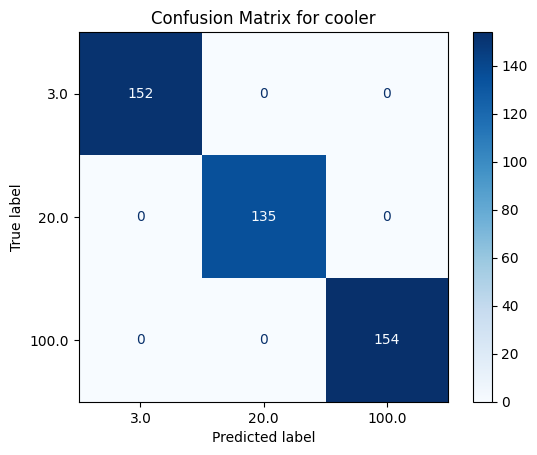

Confusion Matrix for valve:


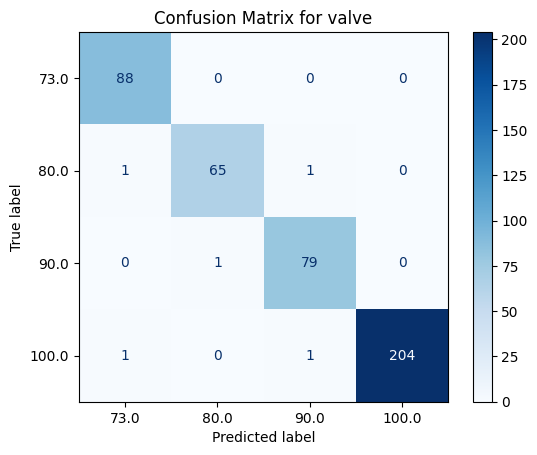

Confusion Matrix for pump:


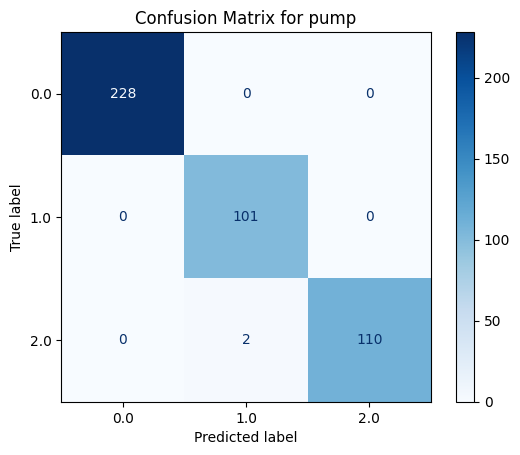

Confusion Matrix for accumulator:


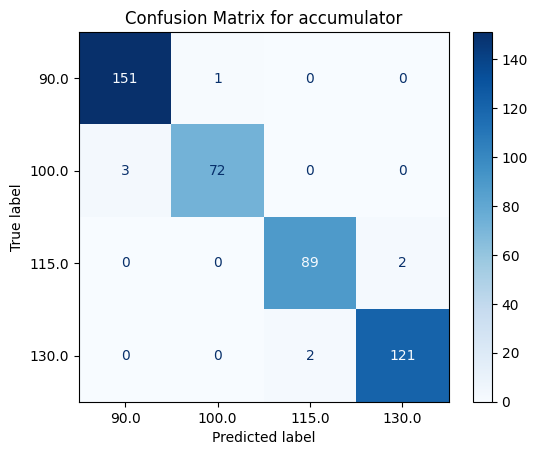

Confusion Matrix for stable:


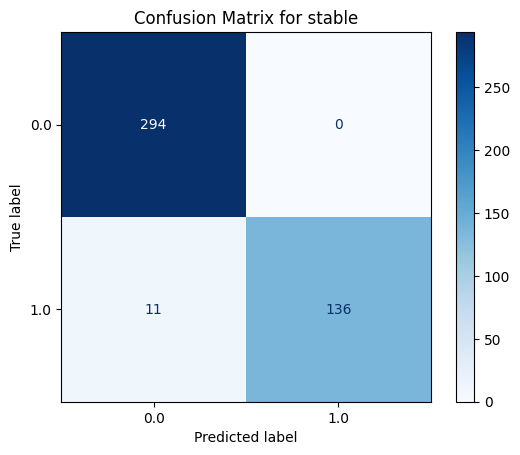

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# For each target variable
for i, target in enumerate(y.columns):
    print(f"Confusion Matrix for {target}:")
    plot_confusion_matrix(y_test.iloc[:, i], y_pred[:, i],
                          classes=sorted(y[target].unique()),
                          title=f"Confusion Matrix for {target}")


Feature Importance for cooler:


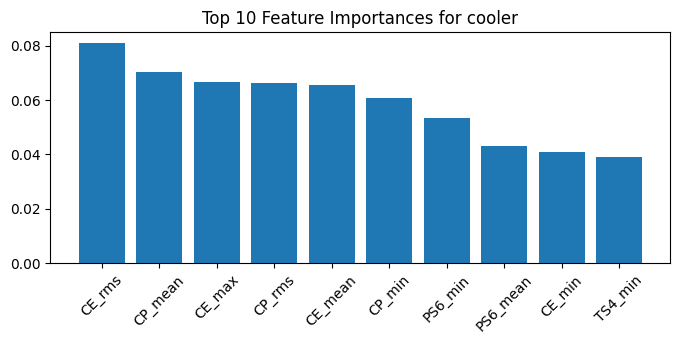

Feature Importance for valve:


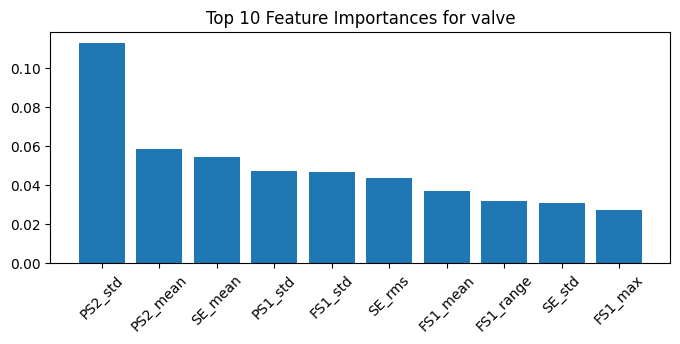

Feature Importance for pump:


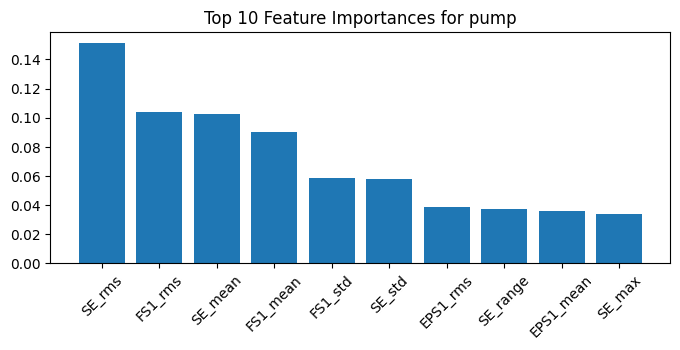

Feature Importance for accumulator:


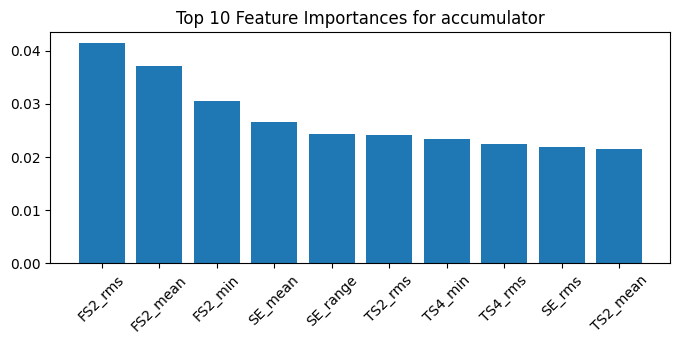

Feature Importance for stable:


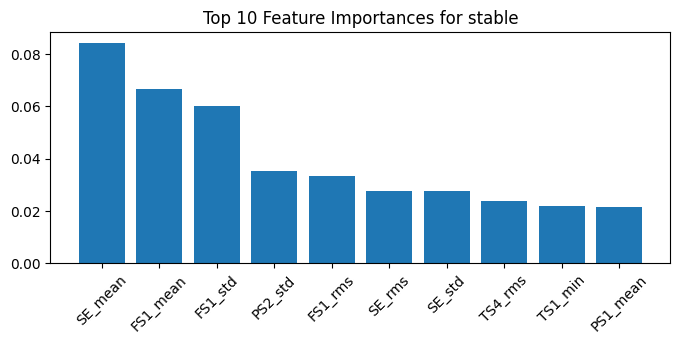

In [ ]:
def plot_feature_importance(model, feature_names, target_name):
    importances = model.feature_importances_
    indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
    sorted_features = [feature_names[i] for i in indices]
    sorted_importances = [importances[i] for i in indices]

    plt.figure(figsize=(8, 3))
    plt.bar(sorted_features[:10], sorted_importances[:10])
    plt.xticks(rotation=45)
    plt.title(f"Top 10 Feature Importances for {target_name}")
    plt.show()

# Example for Random Forest
for i, target in enumerate(y.columns):
    print(f"Feature Importance for {target}:")
    plot_feature_importance(classifiers.estimators_[i], X.columns, target)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming RandomForestClassifier for each label
from sklearn.ensemble import RandomForestClassifier

# Example: Fit separate RandomForest models for each label
feature_importances = {}
for label in ['cooler', 'valve', 'pump', 'accumulator', 'stable']:
    rf = RandomForestClassifier()
    rf.fit(X, y[label])  # X is feature data, y[label] is the target label
    importances = rf.feature_importances_
    feature_importances[label] = pd.Series(importances, index=X.columns)


In [ ]:
most_important_features = {label: feature_importances[label].idxmax() for label in feature_importances}


In [ ]:
most_important_features

{'cooler': 'CP_max',
 'valve': 'PS2_std',
 'pump': 'FS1_rms',
 'accumulator': 'FS2_mean',
 'stable': 'FS1_mean'}

In [ ]:
correlations = {}
for label, feature in most_important_features.items():
    correlations[label] = y[label].corr(X[feature])

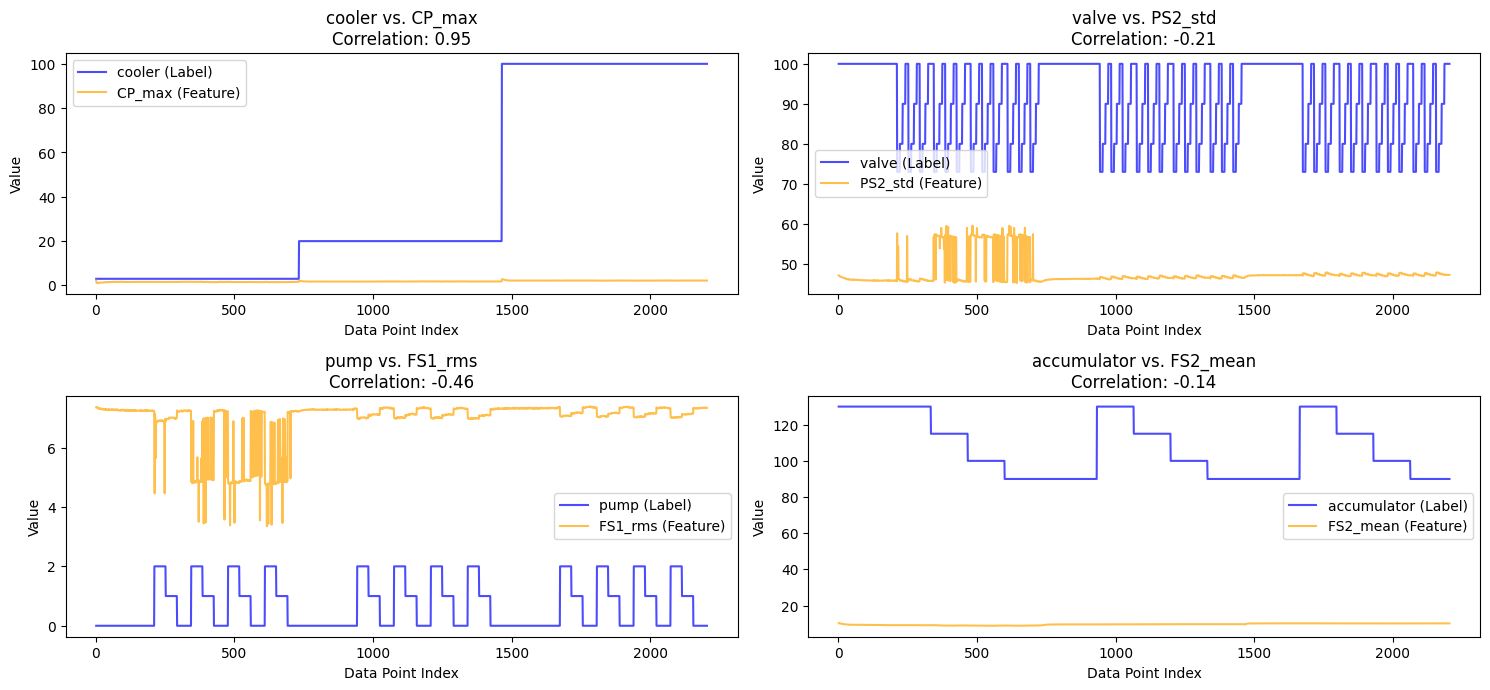

In [ ]:
# Plot settings
indices = range(1, 2206)
plt.figure(figsize=(15, 10))
for i, label in enumerate(['cooler', 'valve', 'pump', 'accumulator']):
    feature = most_important_features[label]
    correlation = correlations[label]

    plt.subplot(3, 2, i + 1)  # Arrange plots in a grid
    plt.plot(indices, y[label], label=f"{label} (Label)", color='blue', alpha=0.7)
    plt.plot(indices, X[feature], label=f"{feature} (Feature)", color='orange', alpha=0.7)
    plt.title(f"{label} vs. {feature}\nCorrelation: {correlation:.2f}")
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Load your data
df = pd.read_csv('sensor_data.csv')  # Replace with your dataset

# Add RUL column (assuming 'time' and 'failure_time' exist)
df['RUL'] = df['failure_time'] - df['time']  # Adjust column names as needed

# Feature scaling
scaler = MinMaxScaler()
sensor_data = scaler.fit_transform(df.iloc[:, :-1])  # Scale all sensor features
rul = df['RUL'].values

# Create sequences for LSTM
def create_sequences(data, rul, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(rul[i + window_size])
    return np.array(X), np.array(y)

window_size = 30  # Number of time steps
X, y = create_sequences(sensor_data, rul, window_size)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window_size, X.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Predict RUL
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Predict RUL
y_pred = model.predict(X_test)


In [9]:
X.columns

Index(['PS1_mean', 'PS1_std', 'PS1_max', 'PS1_min', 'PS1_range', 'PS1_rms',
       'PS2_mean', 'PS2_std', 'PS2_max', 'PS2_min',
       ...
       'CE_max', 'CE_min', 'CE_range', 'CE_rms', 'CP_mean', 'CP_std', 'CP_max',
       'CP_min', 'CP_range', 'CP_rms'],
      dtype='object', length=102)

In [ ]:
# prompt: how to plot subplots with matplotlib

import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.tan(x)


# Method 1: Using plt.subplot

plt.figure(figsize=(10, 8)) # Optional figsize
plt.subplot(2, 2, 1) # (rows, cols, plot number)
plt.plot(x, y1)
plt.title("Plot 1")

plt.subplot(2, 2, 2)
plt.plot(x, y2, color='red')
plt.title("Plot 2")

plt.subplot(2, 2, 3)
plt.plot(x, y3, color='green')
plt.title("Plot 3")
plt.tight_layout()
plt.show()

# Method 2: Using plt.subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8)) # (rows, cols)

axes[0, 0].plot(x, y1)
axes[0, 0].set_title("Plot 1")

axes[0, 1].plot(x, y2, color='red')
axes[0, 1].set_title("Plot 2")

axes[1, 0].plot(x, y3, color='green')
axes[1, 0].set_title("Plot 3")
fig.delaxes(axes[1,1]) # Remove extra empty subplot

plt.tight_layout()
plt.show()


In [14]:
y.columns

Index(['cooler', 'valve', 'pump', 'accumulator', 'stable'], dtype='object')

Text(0.5, 1.0, 'stable')

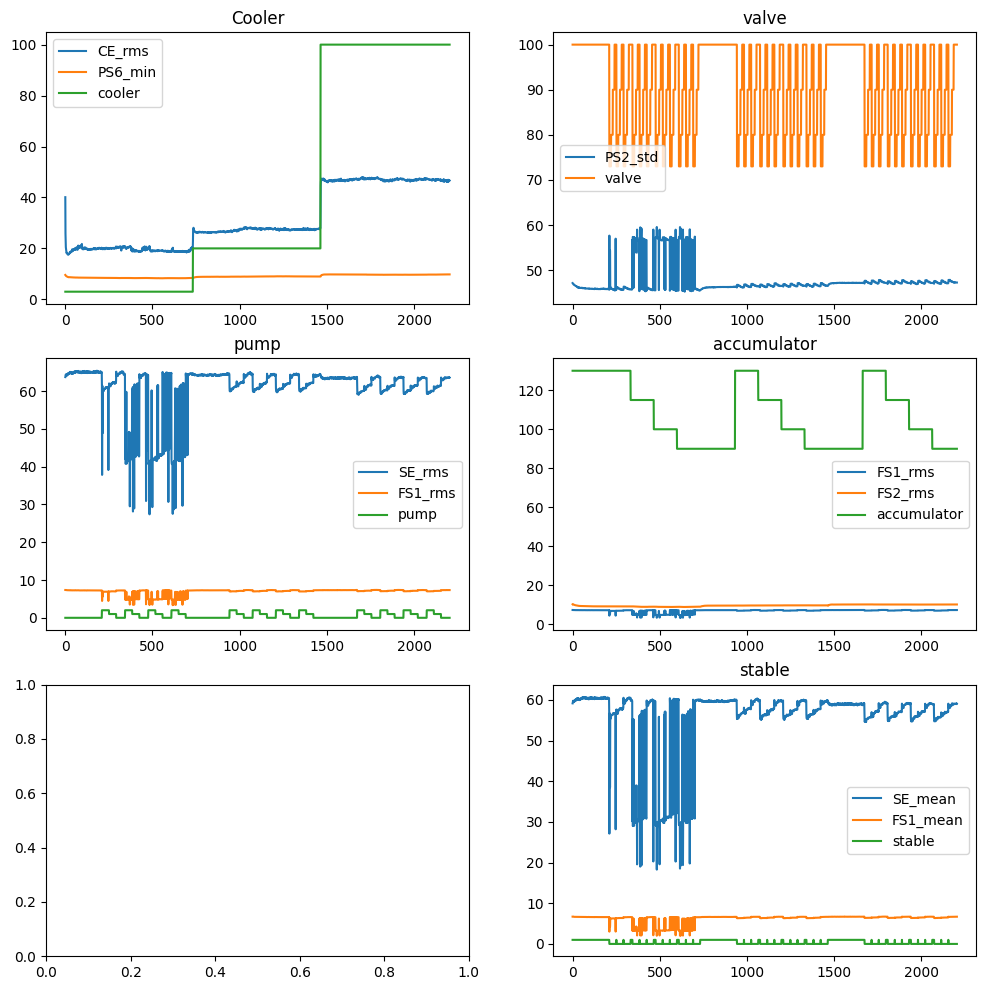

In [19]:
# prompt: plot graphically the values of all sensor mean values like "PS1_mean" across time (2205 records) along with the 5 lable values

import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(12, 12)) # (rows, cols)

# plt.plot(X['PS1_mean'], label='PS1_mean')
# plt.plot(X['PS2_mean'], label='PS2_mean')
axes[0, 0].plot(X['CE_rms'], label='CE_rms')
axes[0, 0].plot(X['PS6_min'], label='PS6_min')
# for label_col in y.columns:
axes[0, 0].plot(y['cooler'], label='cooler')
axes[0, 0].legend()
axes[0, 0].set_title('Cooler')

axes[0, 1].plot(X['PS2_std'], label='PS2_std')
# for label_col in y.columns:
axes[0, 1].plot(y['valve'], label='valve')
axes[0, 1].legend()
axes[0, 1].set_title('valve')

axes[1, 0].plot(X['SE_rms'], label='SE_rms')
axes[1, 0].plot(X['FS1_rms'], label='FS1_rms')
# for label_col in y.columns:
axes[1, 0].plot(y['pump'], label='pump')
axes[1, 0].legend()
axes[1, 0].set_title('pump')

axes[1, 1].plot(X['FS1_rms'], label='FS1_rms')
axes[1, 1].plot(X['FS2_rms'], label='FS2_rms')
# for label_col in y.columns:
axes[1, 1].plot(y['accumulator'], label='accumulator')
axes[1, 1].legend()
axes[1, 1].set_title('accumulator')

axes[2, 1].plot(X['SE_mean'], label='SE_mean')
axes[2, 1].plot(X['FS1_mean'], label='FS1_mean')
# for label_col in y.columns:
axes[2, 1].plot(y['stable'], label='stable')
axes[2, 1].legend()
axes[2, 1].set_title('stable')
# cool - ce-rms ps6-min, valve - ps2std, pump - se-rms fs1-rms, acc - fs2-rms, stable - se-mean fs1-mean

# Assuming 'y' is your labels DataFrame with columns like 'cooler', 'valve', etc.
# Plot labels if you want to overlay the labels in the plot with y-axis values.
# for label_col in y.columns:
#     plt.plot(y[label_col], label=label_col)


# plt.xlabel('Time (Records)')  # Assuming the index represents time
# plt.ylabel('Values')
# plt.title('PS1 Mean and Labels Over Time')
# plt.legend()
# plt.grid(True)
# plt.show()

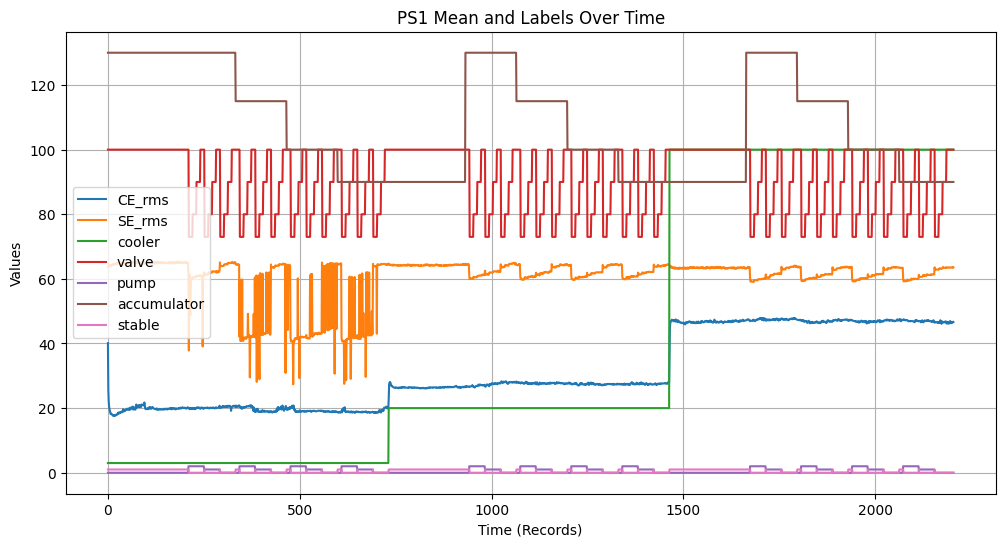

In [12]:
# prompt: plot graphically the values of all sensor mean values like "PS1_mean" across time (2205 records) along with the 5 lable values

import matplotlib.pyplot as plt

# Assuming 'X' DataFrame from your code contains the sensor mean values and 'y' contains labels
# and you have already loaded and preprocessed the data.

# Example: Plotting 'PS1_mean' across time with labels
plt.figure(figsize=(12, 6))
# plt.plot(X['PS1_mean'], label='PS1_mean')
# plt.plot(X['PS2_mean'], label='PS2_mean')
plt.plot(X['CE_rms'], label='CE_rms')
plt.plot(X['SE_rms'], label='SE_rms')
cool - ce-rms ps6-min, valve - ps2std, pump - se-rms fs1-rms, acc - fs2-rms, stable - se-mean fs1-mean

# Assuming 'y' is your labels DataFrame with columns like 'cooler', 'valve', etc.
# Plot labels if you want to overlay the labels in the plot with y-axis values.
for label_col in y.columns:
    plt.plot(y[label_col], label=label_col)


plt.xlabel('Time (Records)')  # Assuming the index represents time
plt.ylabel('Values')
plt.title('PS1 Mean and Labels Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Load and preprocess data
X, y = load_and_preprocess_data(dir)

# Train models
train_condition_models(X, y)
train_rul_model(X)

# Make predictions for new data
new_data = X.iloc[0:1]  # Example: use first instance
conditions = predict_conditions(new_data)
rul = predict_rul(X.iloc[0:10].values)  # Use 10 time steps

print("\nPredicted Conditions:", conditions)
print("Predicted RUL (time steps):", rul)

In [ ]:
data['PS1'].shape

(2205, 6000)

In [ ]:
# Load profile data
raw_data = pd.read_csv(f'{file_paths}/profile.txt', header=None)
profile = preprocess_sensor_data(raw_data)
profile.columns = ['cooler', 'valve', 'pump', 'accumulator', 'stable']

In [ ]:
def train_condition_models( X, y):
    """Train models for predicting component conditions."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    feature_scaler.fit(X_train)
    X_train_scaled = feature_scaler.transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)

    # Train classifiers for discrete conditions
    components = ['cooler', 'valve', 'pump']
    for component in components:
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train_scaled, y_train[component])
        classifiers[component] = clf

        # Print performance metrics
        y_pred = clf.predict(X_test_scaled)
        print(f"\n{component.upper()} Classification Report:")
        print(classification_report(y_test[component], y_pred))

    # Train regressor for accumulator pressure
    regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    regressor.fit(X_train_scaled, y_train['accumulator'])

    # Print regression metrics
    y_pred = regressor.predict(X_test_scaled)
    print("\nAccumulator Regression Metrics:")
    print(f"R2 Score: {r2_score(y_test['accumulator'], y_pred)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test['accumulator'], y_pred))}")

def train_rul_model( X, window_size=10):
    """Train LSTM model for RUL prediction."""
    # Prepare sequences for LSTM
    sequences = []
    targets = []

    for i in range(len(X) - window_size):
        sequences.append(X.iloc[i:i+window_size].values)
        targets.append(X.iloc[i+window_size].values)

    sequences = np.array(sequences)
    targets = np.array(targets)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

    # Create and train LSTM model
    lstm_model = Sequential([
        LSTM(64, input_shape=(window_size, X.shape[1]), return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(X.shape[1])
    ])

    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

    # Evaluate model
    mse = lstm_model.evaluate(X_test, y_test)
    print(f"\nLSTM Model MSE: {mse}")

In [13]:
os.listdir('/content/drive/.shortcut-targets-by-id/1Y1skwwOFlLTH2H9fnNGBQD832P0M5Els/Ingenium/')

['Models', 'Datasets', 'Ingenium .pptx']

In [ ]:
dataset_dir = '/content/drive/.shortcut-targets-by-id/1Y1skwwOFlLTH2H9fnNGBQD832P0M5Els/Ingenium/Datasets'
models_dir = '/content/drive/.shortcut-targets-by-id/1Y1skwwOFlLTH2H9fnNGBQD832P0M5Els/Ingenium/Models'